In [1]:
import sys
sys.path.append('../cython_dbscan')


In [2]:
import pandas as pd
import numpy as np
from dbscan_core import dbscan
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import h3 as h3
import time


In [3]:
df = pd.read_csv('data/sample_by_nav_status.csv')
df.head()

,res_8,nav_status,mmsi
0,881f222c31fffff,Under Way Using Engine,257600000.0
1,881f222c31fffff,Under Way Using Engine,257600000.0
2,881f600c35fffff,Moored,259372000.0
3,88194464e7fffff,Under Way Using Engine,257550000.0
4,88194464e7fffff,Under Way Using Engine,257550000.0


In [4]:
#definicion de parametros
eps_km = 5
min_samples = 3

In [5]:
def safe_cell_to_latlng(h3_str):
    try:
        return h3.cell_to_latlng(str(h3_str))
    except Exception:
        return (np.nan, np.nan)

df["latlon"] = df["res_8"].map(safe_cell_to_latlng)
df[["lat", "lon"]] = pd.DataFrame(df["latlon"].tolist(), index=df.index)

In [6]:
# Eliminar NaN por errores en la conversión
df = df.dropna(subset=["lat", "lon"])
coords = df[["lat", "lon"]].to_numpy()

In [8]:
# ─────────────────────────────────────
# COMPARAR: DBSCAN DE CYTHON
# ─────────────────────────────────────
start = time.perf_counter()
labels_cython = dbscan(np.ascontiguousarray(coords, dtype=np.float64), eps=5, min_samples=3)
df["cluster_cython"] = labels_cython
time_cy = time.perf_counter() - start

In [7]:
# ─────────────────────────────────────
# COMPARAR: DBSCAN DE SKLEARN
# ─────────────────────────────────────
start = time.perf_counter()
coords_rad = np.radians(coords)
labels_sk = DBSCAN(eps=5.0 / 6371, min_samples=3, metric="haversine").fit(coords_rad).labels_
df["cluster_sklearn"] = labels_sk
time_sk = time.perf_counter() - start

In [9]:
# ─────────────────────────────────────
# RESULTADOS BÁSICOS
# ─────────────────────────────────────
print("▶ Clusters (Cython):", np.unique(labels_cython))
print("▶ Clusters (sklearn):", np.unique(labels_sk))

▶ Clusters (Cython): [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137]
▶ Clusters (sklearn): [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  9

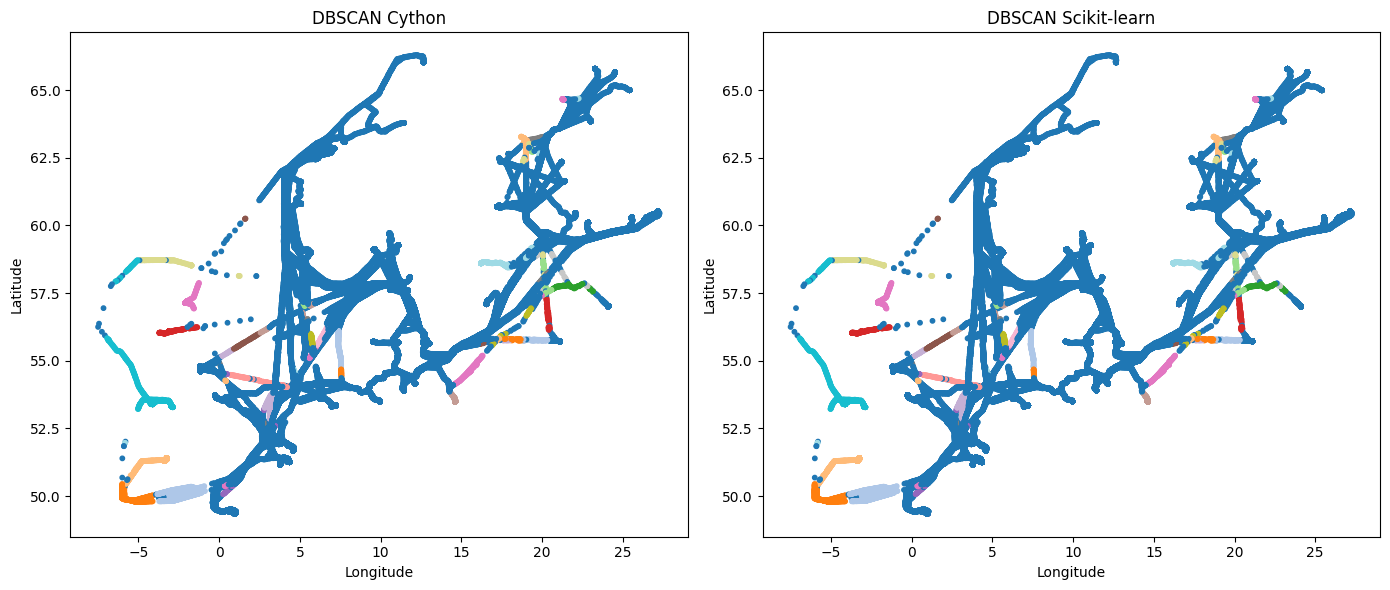

In [10]:
# --- Visualización comparativa ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(df["lon"], df["lat"], c=df["cluster_cython"], cmap="tab20", s=10)
axs[0].set_title("DBSCAN Cython")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

axs[1].scatter(df["lon"], df["lat"], c=df["cluster_sklearn"], cmap="tab20", s=10)
axs[1].set_title("DBSCAN Scikit-learn")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [9]:
# --- Bloque de rendimiento ---
print("\n--- Comparación de rendimiento ---")
print(f"DBSCAN Cython     : {time_cy:.4f} segundos")
print(f"DBSCAN Scikit-learn: {time_sk:.4f} segundos")


--- Comparación de rendimiento ---
DBSCAN Cython     : 136.8014 segundos
DBSCAN Scikit-learn: 0.7133 segundos
